In [8]:
# Setup: installs (if missing) and imports
import sys
import subprocess
import pkgutil

def install(pkg):
    print(f"Installing {pkg}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Packages required for this notebook
needed = ["gensim", "scikit-learn", "matplotlib", "numpy"]
for p in needed:
    if pkgutil.find_loader(p) is None:
        install(p)

# Optional: pyspark (only if the user wants to run Spark demo)
pyspark_available = pkgutil.find_loader("pyspark") is not None
if not pyspark_available:
    print("PySpark not found. To run Spark demo, install pyspark and ensure Java is available: pip install pyspark")

# Imports
import os
import math
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

logging.getLogger().setLevel(logging.INFO)

# Controls
DOWNLOAD_PRETRAINED = True  # Set to False to skip downloading the ~65MB GloVe model
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

print("Setup complete. pyspark_available=", pyspark_available)

Installing scikit-learn...
PySpark not found. To run Spark demo, install pyspark and ensure Java is available: pip install pyspark
Setup complete. pyspark_available= False
PySpark not found. To run Spark demo, install pyspark and ensure Java is available: pip install pyspark
Setup complete. pyspark_available= False


In [2]:
# Tokenizers & CountVectorizer implementations (self-contained)
import re
from collections import defaultdict, Counter

class SimpleTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        if text is None:
            return []
        return [t for t in re.findall(r"\w+|[^\\w\s]", text.lower())]

class RegexTokenizer:
    def __init__(self, pattern=r"\w+|[^\w\s]"):
        self.pattern = re.compile(pattern)
    def tokenize(self, text):
        if text is None:
            return []
        return [t for t in self.pattern.findall(text.lower())]

class CountVectorizerSimple:
    def __init__(self):
        self.vocab_ = {}
        self.inv_vocab_ = {}
    def fit(self, documents):
        freq = Counter()
        for d in documents:
            freq.update(d)
        # sort tokens for reproducibility
        tokens = sorted(freq.keys())
        self.vocab_ = {t:i for i,t in enumerate(tokens)}
        self.inv_vocab_ = {i:t for t,i in self.vocab_.items()}
        return self
    def transform(self, documents):
        rows = []
        for d in documents:
            vec = [0]*len(self.vocab_)
            for t in d:
                if t in self.vocab_:
                    vec[self.vocab_[t]] += 1
            rows.append(vec)
        return np.array(rows)
    def fit_transform(self, documents):
        self.fit(documents)
        return self.transform(documents)

print('Tokenizers and CountVectorizer ready')

Tokenizers and CountVectorizer ready


In [3]:
# WordEmbedder: wrapper for gensim pre-trained and for gensim Word2Vec
from gensim import downloader as api
from gensim.models import Word2Vec

class WordEmbedder:
    def __init__(self, model=None, model_name='glove-wiki-gigaword-50'):
        self.model = model
        self.model_name = model_name
    def load_pretrained(self, download=True):
        if download:
            print(f"Loading pretrained model {self.model_name} (this may download ~60MB)...")
            self.model = api.load(self.model_name)
        else:
            raise RuntimeError('Pretrained download disabled')
        return self.model
    def get_vector(self, word):
        if self.model is None:
            return None
        try:
            return self.model[word]
        except Exception:
            return None
    def similarity(self, w1, w2):
        if self.model is None:
            return None
        try:
            return float(self.model.similarity(w1, w2))
        except Exception:
            return None
    def most_similar(self, word, topn=10):
        if self.model is None:
            return []
        try:
            return self.model.most_similar(word, topn=topn)
        except Exception:
            return []
    def embed_document_mean(self, tokens):
        vecs = [self.get_vector(t) for t in tokens]
        vecs = [v for v in vecs if v is not None]
        if not vecs:
            return np.zeros(self.model.vector_size if hasattr(self.model,'vector_size') else 50)
        return np.mean(vecs, axis=0)

print('WordEmbedder ready')

WordEmbedder ready


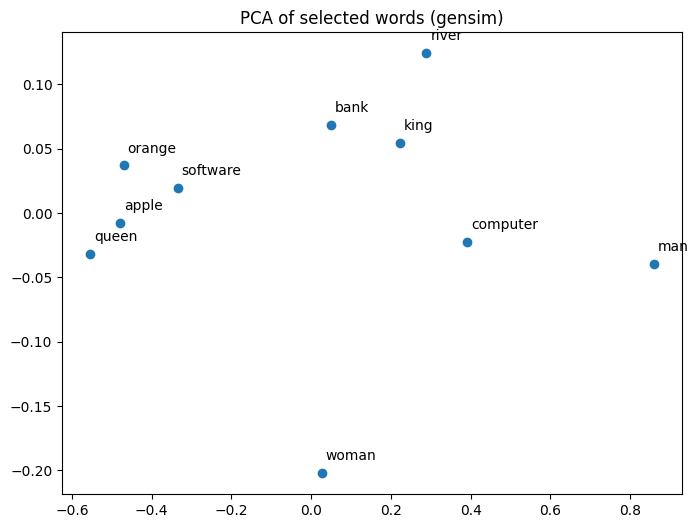

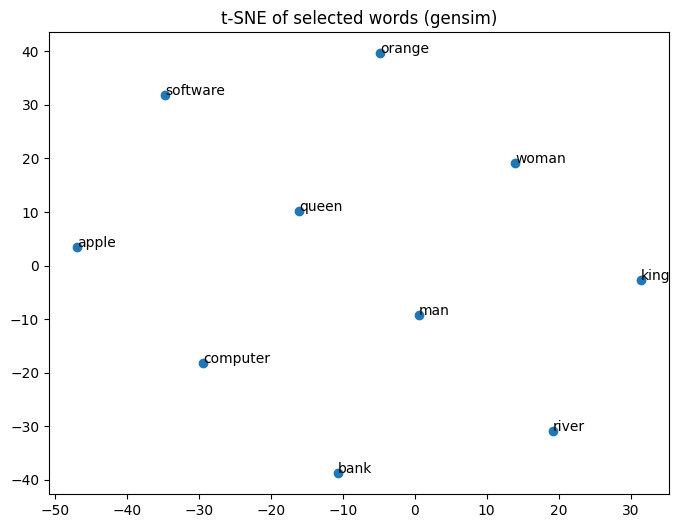

In [11]:
# Task 5: Visualization (PCA & t-SNE) using available vectors
vec_source = None
if pretrained_loaded:
    vec_source = ('pretrained', we)
elif gensim_trained:
    vec_source = ('gensim', w2v)
else:
    print('No vector source available for visualization')

if vec_source is not None:
    source_name, src = vec_source
    words = ['king','queen','man','woman','computer','software','apple','orange','bank','river']
    vectors = []
    for w in words:
        if source_name == 'pretrained':
            v = we.get_vector(w)
        else:
            try:
                v = src.wv[w]
            except Exception:
                v = None
        if v is not None:
            vectors.append((w, v))
    if len(vectors) >= 2:
        W, V = zip(*vectors)
        V = np.stack(V)
        # PCA
        pca = PCA(n_components=2)
        proj = pca.fit_transform(V)
        plt.figure(figsize=(8,6))
        plt.scatter(proj[:,0], proj[:,1])
        for i,w in enumerate(W):
            plt.text(proj[i,0]+0.01, proj[i,1]+0.01, w)
        plt.title(f'PCA of selected words ({source_name})')
        pca_out = RESULTS_DIR / f'word_vectors_pca_{source_name}.png'
        plt.savefig(pca_out)
        plt.show()

        # t-SNE (choose perplexity that is < n_samples)
        try:
            n_samples = V.shape[0]
            perp = min(30, max(1, n_samples - 1))
            if perp >= 1:
                tsne = TSNE(n_components=2, random_state=42, perplexity=max(1, perp))
                tsne_proj = tsne.fit_transform(V)
                plt.figure(figsize=(8,6))
                plt.scatter(tsne_proj[:,0], tsne_proj[:,1])
                for i,w in enumerate(W):
                    plt.text(tsne_proj[i,0]+0.01, tsne_proj[i,1]+0.01, w)
                plt.title(f't-SNE of selected words ({source_name})')
                tsne_out = RESULTS_DIR / f'word_vectors_tsne_{source_name}.png'
                plt.savefig(tsne_out)
                plt.show()
                visualization_done = True
            else:
                print('t-SNE skipped due to insufficient samples')
        except Exception as e:
            print('t-SNE failed or too slow:', e)
            visualization_done = False
    else:
        print('Not enough vectors for visualization')

In [12]:
# Quick status check: pretrained vs gensim trained
print('status:', status)
print('pretrained_loaded:', pretrained_loaded)
if pretrained_loaded and we is not None:
    try:
        print('Pretrained sim(king,queen)=', we.similarity('king','queen'))
        print('Pretrained most_similar(computer)=', we.most_similar('computer', topn=5))
    except Exception as e:
        print('Pretrained model query failed:', e)
else:
    print('Pretrained model not loaded')

print('gensim_trained:', gensim_trained)
if gensim_trained:
    try:
        print('Gensim most_similar(work)=', w2v.wv.most_similar('work', topn=5))
    except Exception as e:
        print('Query gensim failed:', e)


status: {'pretrained_loaded': False, 'gensim_trained': True, 'spark_trained': False, 'visualization_done': False}
pretrained_loaded: False
Pretrained model not loaded
gensim_trained: True
Gensim most_similar(work)= [('thing', 0.9974221587181091), ('back', 0.9960651397705078), ('him', 0.9959415197372437), ('parents', 0.995270848274231), ('much', 0.9946041107177734)]


In [5]:
# Diagnostics: check working dir and data files
from pathlib import Path
print('CWD:', Path.cwd())
data_dir = Path('data')
print('data exists:', data_dir.exists())
if data_dir.exists():
    print('data children:', [p.name for p in sorted(data_dir.iterdir())])
    ewt = Path('data/UD_English-EWT/en_ewt-ud-train.txt')
    print('EWT path exists:', ewt.exists())
    if ewt.exists():
        print('EWT size (bytes):', ewt.stat().st_size)
    else:
        # look for similar files
        print('Looking for UD_English-EWT folder content:')
        ud_folder = data_dir / 'UD_English-EWT'
        if ud_folder.exists():
            print(list(ud_folder.iterdir())[:10])


CWD: c:\Users\Quan\.vscode-R\NLP-APP\notebook
data exists: False
